# Synthetic Data

In [1]:
import numpy as np
from numpy import logical_or as lor
from numpy import logical_and as land
from numpy import logical_not as lnot
from numpy import logical_xor as lxor
import random
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# generate a list of all possible combinations of 3-bits
def gen_3(): 
  rlvnt = []
  for i in [0,1]:
    for j in [0,1]:
      for k in [0,1]:
        rlvnt.append([i,j,k])
  return rlvnt

# create 2 correlated features in case of binary target (y) 
# by randomly fliping 30% of the values of y  

def make_cor(y):
  random.seed(0)
  cor_vars = []
  for i in range(2):
    cor_i = y.copy()
    ind = random.sample(range(len(y)), int(0.3*len(y)))
    cor_i[ind] = lnot(cor_i[ind])
    cor_vars.append(cor_i)
  return np.array(cor_vars).transpose()

### ORAND

In [3]:
def orand(n_obs=50,n_I=98, seed=0):
  np.random.seed(seed)
  red = lnot(gen_3()).astype(int) #redundant variables
  rr = np.hstack([gen_3(), red]) #rlvnt & rdnt joined
  q=n_obs//8
  r=n_obs%8
  rr_exp = np.vstack([np.repeat(rr,q, axis=0),rr[:r,:]]) #replicate rr according to n_obs
  irlvnt = np.random.randint(2, size=[n_obs,n_I], )
  y = land(rr_exp[:,0], 
           lor(rr_exp[:,1], rr_exp[:,2])).astype(int) #calculate y according to the formula
  cor = make_cor(y)
  features = np.hstack([rr_exp,cor, irlvnt])
  return features, y

X, y = orand(seed=1)

### ANDOR

In [4]:
# generate a list of all possible combinations of 3-bits
def gen_4():
  rlvnt_0 = gen_3()
  for seq in rlvnt_0:
    seq.append(0)

  rlvnt_1 = gen_3()
  for seq in rlvnt_1:
    seq.append(1)

  return rlvnt_0 + rlvnt_1


def andor(n_obs=50,n_I=90, seed=0):
  np.random.seed(seed)
  red = lnot(gen_4()).astype(int)
  rr = np.hstack([gen_4(), red])
  q=n_obs//16
  r=n_obs%16
  rr_exp = np.vstack([np.repeat(rr,q, axis=0),rr[:r,:]])
  irlvnt = np.random.randint(2, size=[n_obs,n_I])
  y = lor(land(rr_exp[:,0], rr_exp[:,1]), 
          land(rr_exp[:,2], rr_exp[:,3])).astype(int)
  cor = make_cor(y)
  features = np.hstack([rr_exp, cor, irlvnt])
  return features, y

X, y = andor()

### ADDER

In [5]:
# make 2 correlated features when n_class => 2
# this is more general than make_cor which works only when n_class=2
# works by adding 1 to the y value and modding 
# flips 30% of y values

def make_cor_adv(y, n_class=4):
  n_ind = int(0.3*len(y))
  cor_vars = []
  for i in range(2):
    random.seed(0)
    np.random.seed(0)
    cor_i = y.copy()
    ind = random.sample(range(len(y)), n_ind)
    adjust = np.random.randint(n_class, size=n_ind)
    cor_i[ind] = (cor_i[ind]+adjust)%n_class
    cor_vars.append(cor_i)
  return np.array(cor_vars).transpose()

In [6]:
def adder(n_obs=50,n_I=92, seed=0):
  np.random.seed(seed)
  red = lnot(gen_3()).astype(int)
  rr = np.hstack([gen_3(), red])
  q=n_obs//8
  r=n_obs%8
  rr_exp = np.vstack([np.repeat(rr,q, axis=0),rr[:r,:]])
  irlvnt = np.random.randint(2, size=[n_obs,n_I])
  y1 = lxor(lxor(rr_exp[:,0], rr_exp[:,1]), 
            rr_exp[:,2]).astype(int)
  y2 = lor(land(rr_exp[:,0], rr_exp[:,1]), 
           land(rr_exp[:,2], lxor(rr_exp[:,0], rr_exp[:,1]))).astype(int)
  y = [y1[j] + 2*y2[j] for j in range(len(y1))]
  cor = make_cor_adv(np.array(y))
  features = np.hstack([rr_exp, cor, irlvnt])
  return features, y

X, y = adder(n_obs=50,n_I=92, seed=0)

### LED

In [7]:
# import the table showing which LED segments light up for each character
df = pd.read_csv('16_segment_truth_table2.csv')
#df = pd.read_csv('5D_XOR.csv')
df = df.fillna(0)
df.index = df.iloc[:,0].values
df.drop(columns='char', inplace=True)
df = df.astype(int)

def led(df, n_obs=180,n_I=66, seed=0):
    np.random.seed(seed)
    rlvnt = df.values
    red = np.logical_not(rlvnt)
    rr = np.hstack([rlvnt, red])
    d = rlvnt.shape[0]
    q=n_obs//d
    r=n_obs%d
    rr_exp = np.vstack([np.repeat(rr, q, axis=0), rr[:r,:]])
    irlvnt = np.random.randint(2, size=[n_obs,n_I])
    y = np.array(range(36))
    y = np.hstack([np.repeat(y, q), y[:r]])
    cor = make_cor_adv(y, n_class=36)
    features = np.hstack([rr_exp, cor, irlvnt])
    return features, y
    
    
X, y = led(n_obs=180,n_I=90, df=df)

### PRC

In [8]:
def r_total(r_array):
  r_sum = 0
  for k in range(5):
    rk_sum = 1
    for j in range(5):
      if j!=k:
        rk_sum = rk_sum*r_array[j]
    r_sum = r_sum + rk_sum
  return np.prod(r_array)/r_sum



def prc(n_obs,n_I, seed):
  np.random.seed(seed)
  rlvnt = 3 + np.random.randn(n_obs,5)/3
  red = 2*rlvnt+3   #redundant features are linear transform of relevant variables
  rr = np.hstack([rlvnt, red])

  irlvnt = 3 + np.random.randn(n_obs,n_I//2)/3
  irlvnt = np.hstack([irlvnt, 3+np.random.rand(n_obs,n_I//2)])
  
  features = np.hstack([rr, irlvnt])
  y = [r_total(features[j,:5]) for j in range(features.shape[0])]
  return features, y

X, y = prc(50, 90, 0)

## Example with ANDOR

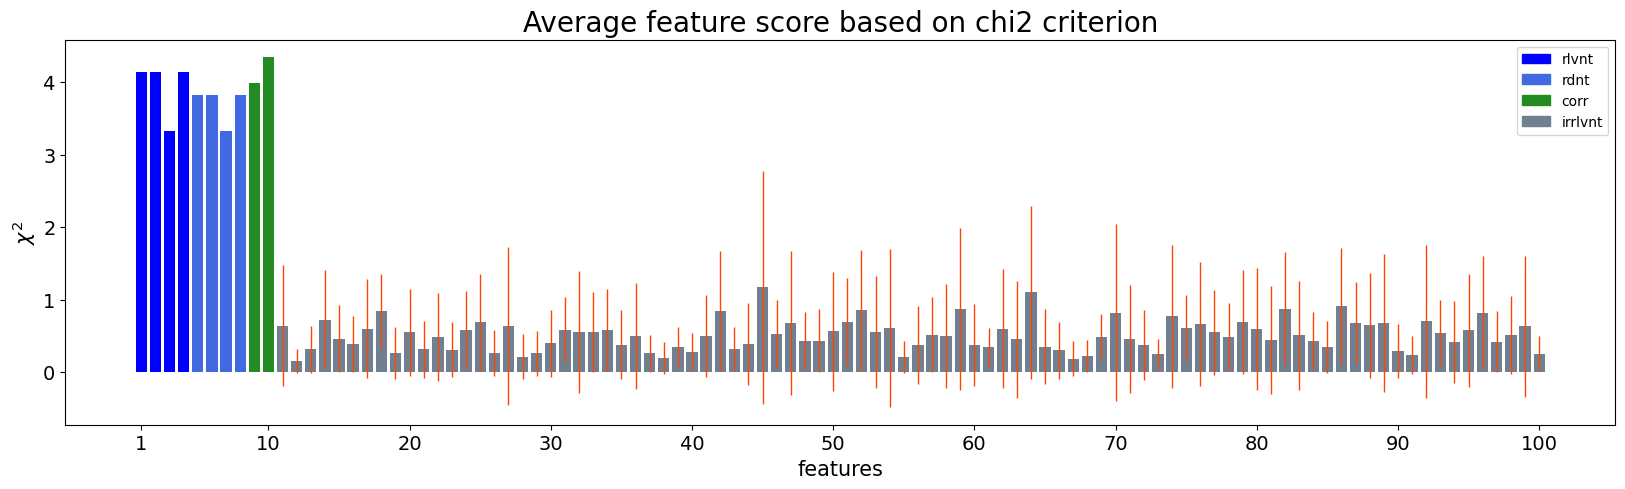

In [9]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#Calculate feature importances based on chi2-score
#Perform the experiment 10 times with different seeds for irrelevant variables
#Sum the scores for each feature
best_scores = []
for i in range(10):
    X, y = andor(n_obs=50,seed=i) 
    sel_kbest = SelectKBest(chi2, k=1)
    sel_kbest = sel_kbest.fit(X, y)
    best_scores.append(sel_kbest.scores_)

#Plot the average feature scores
plt.figure(figsize=(20,5))
mean_scores = np.array(best_scores).mean(axis=0)
sd_scores = np.array(best_scores).std(axis=0)
plt.bar(range(1, X.shape[1]+1),mean_scores, yerr=sd_scores, ecolor='orangered', 
        color=4*["blue"]+4*["royalblue"]+2*["forestgreen"]+90*["slategray"],
        error_kw=dict(lw=1))
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], size=14)
plt.yticks(size=14)
plt.xlabel('features', size=15)
plt.ylabel(r'$\chi^2$', size=15)
plt.title('Average feature score based on chi2 criterion', size=20)

colors = {'rlvnt':'blue', 'rdnt':'royalblue', 'corr':'forestgreen', 'irrlvnt':'slategray'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.show()

## The below code has been added by the group.
### We have introduced a new dataset 
#### XOR-MUX 
#### Y=S⋅(A⊕B)+(1−S)⋅(A⋅B)

## Example with XOR-MUX

In [10]:
def xormux(n_obs=50, n_I=92, seed=0):
    np.random.seed(seed)
    A = np.random.randint(2, size=n_obs)
    B = np.random.randint(2, size=n_obs)
    S = np.random.randint(2, size=n_obs)

    # XOR-MUX logic
    xor_result = np.logical_xor(A, B).astype(int)
    and_result = np.logical_and(A, B).astype(int)
    y = (S * xor_result + (1 - S) * and_result).astype(int)

    # Create irrelevant and redundant features
    irlvnt = np.random.randint(2, size=[n_obs, n_I])
    redundant = np.vstack([A, B, S]).T  # Redundant features

    # Combine features
    features = np.hstack([redundant, irlvnt])
    return features, y

# Generate dataset
X, y = xormux(seed=1)


### Implementation of Chi2-Score on the XOR-MUX

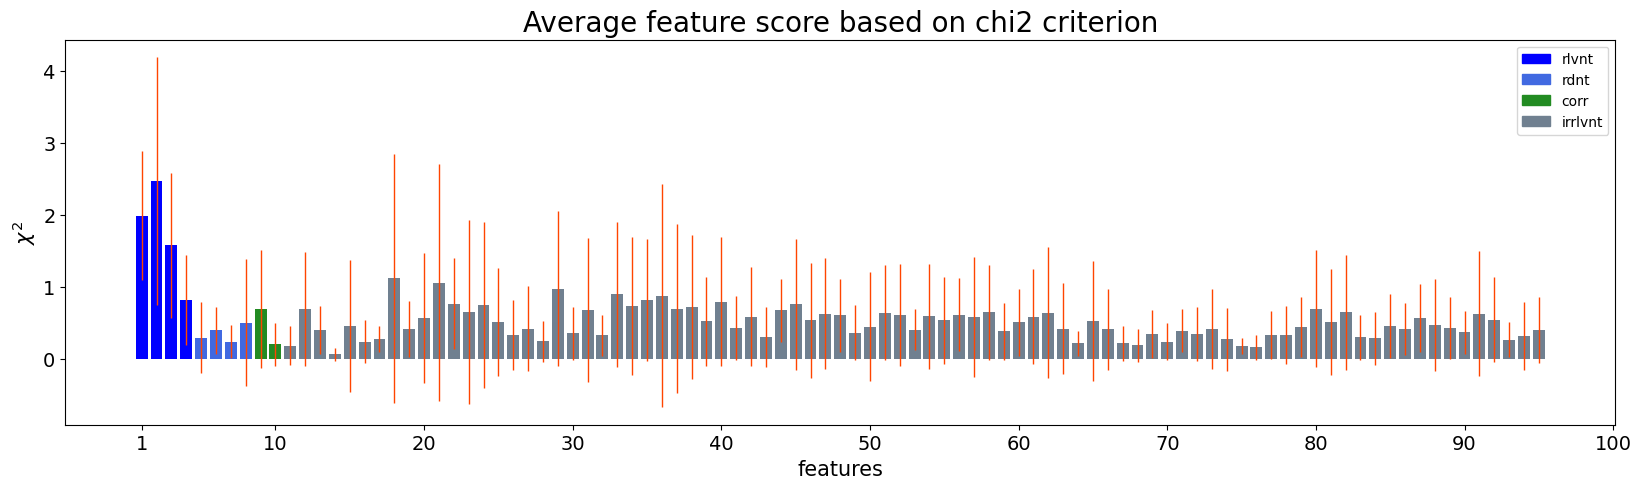

In [11]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#Calculate feature importances based on chi2-score
#Perform the experiment 10 times with different seeds for irrelevant variables
#Sum the scores for each feature
best_scores = []
for i in range(10):
    X, y = xormux(seed=i) 
    sel_kbest = SelectKBest(chi2, k=1)
    sel_kbest = sel_kbest.fit(X, y)
    best_scores.append(sel_kbest.scores_)

#Plot the average feature scores
plt.figure(figsize=(20,5))
mean_scores = np.array(best_scores).mean(axis=0)
sd_scores = np.array(best_scores).std(axis=0)
plt.bar(range(1, X.shape[1]+1),mean_scores, yerr=sd_scores, ecolor='orangered', 
        color=4*["blue"]+4*["royalblue"]+2*["forestgreen"]+90*["slategray"],
        error_kw=dict(lw=1))
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], size=14)
plt.yticks(size=14)
plt.xlabel('features', size=15)
plt.ylabel(r'$\chi^2$', size=15)
plt.title('Average feature score based on chi2 criterion', size=20)

colors = {'rlvnt':'blue', 'rdnt':'royalblue', 'corr':'forestgreen', 'irrlvnt':'slategray'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.show()

### Implementation of Chi2-Score on the Hybrid Wrapper-Embedded Feature Selection

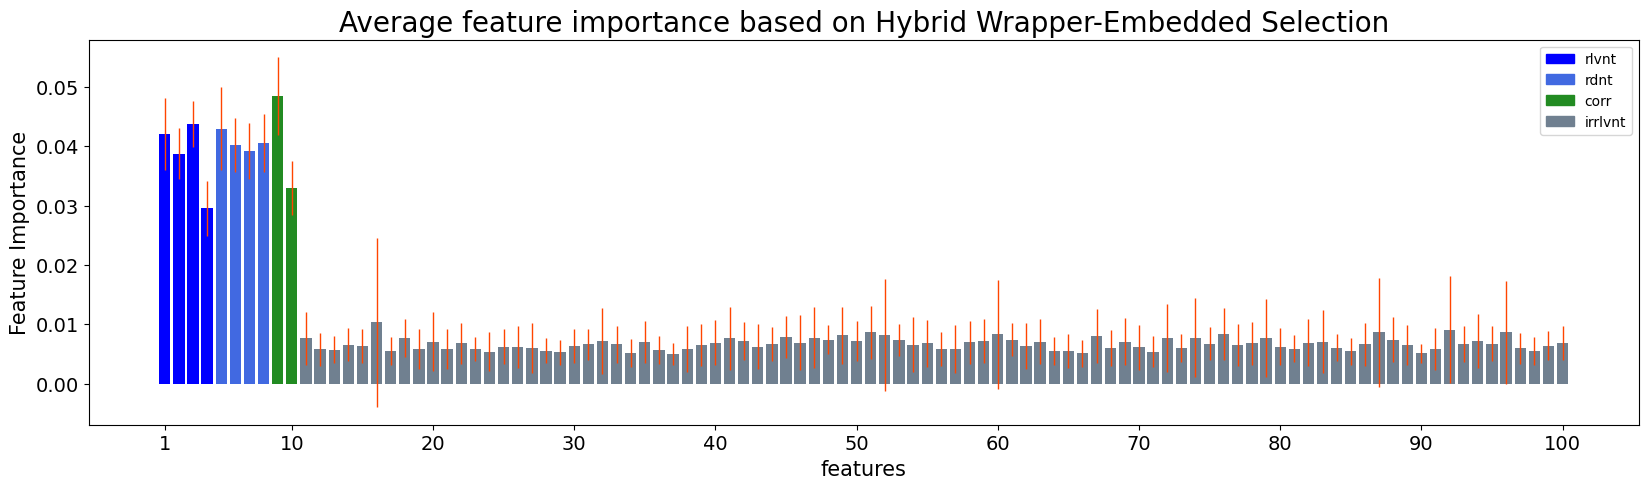

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

# Define the Hybrid Wrapper-Embedded Feature Selection function
def hybrid_feature_selection(X, y, n_features=10):
    # Step 1: Embedded method to rank features
    embedded_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
    embedded_model.fit(X, y)
    feature_importances = embedded_model.feature_importances_
    ranked_features = np.argsort(feature_importances)[::-1]  # Descending order

    # Select top-ranked features
    top_features = ranked_features[:n_features]
    X_top = X[:, top_features]

    # Step 2: Wrapper method for subset evaluation
    wrapper_model = LogisticRegression(random_state=42, max_iter=1000)
    rfe = RFE(wrapper_model, n_features_to_select=5)
    rfe.fit(X_top, y)
    selected_features = top_features[rfe.support_]

    # Return feature rankings
    return feature_importances

# Perform the experiment 20 times with different seeds for irrelevant variables
best_scores = []
for i in range(20):
    X, y = andor(n_obs=60, seed=i)  # Assuming `andor` is the dataset generator
    scores = hybrid_feature_selection(X, y, n_features=10)
    best_scores.append(scores)

# Plot the average feature scores
plt.figure(figsize=(20, 5))
mean_scores = np.array(best_scores).mean(axis=0)
sd_scores = np.array(best_scores).std(axis=0)
plt.bar(range(1, X.shape[1] + 1), mean_scores, yerr=sd_scores, ecolor='orangered', 
        color=4 * ["blue"] + 4 * ["royalblue"] + 2 * ["forestgreen"] + 90 * ["slategray"],
        error_kw=dict(lw=1))
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], size=14)
plt.yticks(size=14)
plt.xlabel('features', size=15)
plt.ylabel('Feature Importance', size=15)
plt.title('Average feature importance based on Hybrid Wrapper-Embedded Selection', size=20)

colors = {'rlvnt': 'blue', 'rdnt': 'royalblue', 'corr': 'forestgreen', 'irrlvnt': 'slategray'}
labels = list(colors.keys())
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.show()

#### Implications for Hybrid Wrapper-Embedded Approach:
##### Strengths:
Combining RFE and Extra Trees may stabilize performance by leveraging the strength of embedded methods for feature ranking and wrappers for subset evaluation. This hybrid approach is expected to outperform standalone RFE by reducing variability across random seeds.
##### Challenges:
Differentiating relevant features from redundant and correlated ones remains difficult.
Smaller datasets significantly degrade performance, even for hybrid models.